# Mixed Likelihood GPLVM

In [1]:
import time
import sys
import os
gpdir = os.path.abspath("../..")
sys.path.append(gpdir)

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

In [3]:
import gp
from gp.util.data import oilflow
from gp.model import MLGPLVM

In [4]:
np.random.seed(1)

## Generate data

In [5]:
num_data = 100
latent_dim = 2
y_obs, likelihoods, labels = oilflow(num_data)
y = tf.convert_to_tensor(y_obs, dtype=tf.float32)

## Create model

In [6]:
m = MLGPLVM(y, latent_dim, likelihoods=likelihoods)

## Build graph

In [7]:
loss = m.loss()
learning_rate = 5e-4
with tf.name_scope("train"):
    with tf.variable_scope("", reuse=tf.AUTO_REUSE):
        u_vars = [tf.get_variable("qu/mean"), tf.get_variable("qu/log_scale")]
        non_u_vars = [tf.get_variable("z"), tf.get_variable("qx/mean"), tf.get_variable("qx/log_std"),
                      ]#tf.get_variable("kern/log_variance"), tf.get_variable("kern/log_gamma")]
        train_x = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, var_list=non_u_vars, name="train_x")
        train_u = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, var_list=u_vars, name="train_u")

with tf.name_scope("summary"):
    tf.summary.scalar("kl_qx_px", m.kl_qx_px(), collections=["training"])
    tf.summary.scalar("kl_qu_pu", m.kl_qu_pu(), collections=["training"])
    tf.summary.scalar("expectation", m.mc_expectation(), collections=["training"])
    tf.summary.scalar("training_loss", loss, collections=["training"])
    tf.summary.scalar("kern_var", tf.squeeze(m.kern._variance), collections=["training"])
    tf.summary.scalar("kern_gamma", tf.squeeze(m.kern._gamma), collections=["training"])
    tf.summary.histogram("qx_mean", m.qx_mean, collections=["training"])
    tf.summary.histogram("qx_std", m.qx_std, collections=["training"])
    tf.summary.histogram("z", m.z, collections=["training"])
    tf.summary.histogram("qu_mean", m.qu_mean, collections=["training"])
    tf.summary.histogram("qu_scale", m.qu_scale, collections=["training"])
    merged_summary = tf.summary.merge_all("training")

init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Run optimisation

KeyboardInterrupt: 

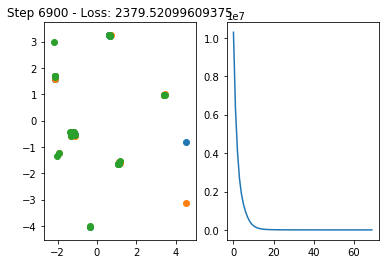

In [9]:
loss_list = []
f, (ax1, ax2) = plt.subplots(1, 2)
n_iter = 50000
n_print = 100
with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(f"../../log/{time.strftime('%Y%m%d%H%M%S')}", sess.graph)
    print("Initializing variables...")
    sess.run(init)
    print(f"Initial loss: {sess.run(loss)}")
    print("Starting training...")
    for i in range(n_iter):
        sess.run(train_x)
        sess.run(train_u)
        if i % n_print == 0:
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            train_loss, summary = sess.run([loss, merged_summary], options=run_options, run_metadata=run_metadata)
            summary_writer.add_run_metadata(run_metadata, f"step{i}")
            summary_writer.add_summary(summary, i)
            loss_print = f"Step {i} - Loss: {train_loss}"
            x_mean = sess.run(m.qx_mean)
            z = sess.run(m.z)
            
            ax1.scatter(*x_mean[labels == 0].T)
            ax1.scatter(*x_mean[labels == 1].T)
            ax1.scatter(*x_mean[labels == 2].T)
            #plt.scatter(z[:, 0], z[:, 1], c="k", marker="x")
            ax1.set_title(loss_print)
            
            loss_list.append(train_loss)
            ax2.plot(loss_list)
            
            display.display(f)
            display.clear_output(wait=True)
            ax1.cla()
            ax2.cla()

In [ ]:
y_obs.shape